In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#import datetime
#from cassandra.cluster import Cluster
import CovidAPI 

In [30]:
api = CovidAPI.API()
data = api.getWorld()

print(len(data))

195


In [38]:
ConfirmedCases = np.zeros((len(data)))

for i in range(len(data)):
    ConfirmedCases[i] = data[i]["TotalConfirmed"]

ConfirmedCases = np.sort(ConfirmedCases)


Train = ConfirmedCases[:-14]
Val = ConfirmedCases[-28:-7]
Test = ConfirmedCases[-21:]


x_train = np.zeros((167, 1, 14))
y_train = np.zeros((167, 1))
x_val = np.zeros((7, 1, 14))
y_val = np.zeros((7, 1))
x_test = np.zeros((7, 1, 14))
y_test = np.zeros((7, 1))


for i in range(Train.shape[0] - 14):
    x_train[i] = Train[i:i+14]
    y_train[i] = Train[i+14]


for i in range(Val.shape[0] - 14):
    x_val[i] = Val[i:i+14]
    y_val[i] = Val[i+14]


for i in range(Test.shape[0] - 14):
    x_test[i] = Test[i:i+14]
    y_test[i] = Test[i+14]



In [126]:
'''
! ls
data = np.load("CountryCases.npy", allow_pickle=True, encoding='bytes')

X = np.zeros((36124, 1, 14))
Y = np.zeros((36124, 1, 1))

index = 0

for i, country in enumerate(data):
    for j in range(len(country) - 14):
        X[index] = country[j:j+14]
        Y[index] = country[j+14]
        index +=1
        
print(index)
print(X.shape, Y.shape)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
'''

36124
(36124, 1, 14) (36124, 1, 1)
(27093, 1, 14) (9031, 1, 14) (27093, 1, 1) (9031, 1, 1)


In [70]:
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM, GaussianNoise, ReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.metrics import RootMeanSquaredError
from keras.losses import mean_squared_error
import keras
import tensorflow.keras.backend as K

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(mean_squared_error(y_true, y_pred))

In [73]:
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        
        y_ = model.predict(x_test[0])
        print("End epoch {} of training; got prediction: {}".format(epoch, y_))

model = Sequential()
model.add(GaussianNoise(0.01))
model.add(LSTM(50, input_shape=(1, 14), return_sequences=True, stateful=True))
model.add(LSTM(50, input_shape=(1, 50), return_sequences=True, stateful=True))
model.add(LSTM(50, input_shape=(1, 50), return_sequences=True, stateful=False))
model.add(Dropout(0.3))
model.add(Dense(1))
model.add(ReLU())
model.compile(loss=root_mean_squared_error, optimizer=tf.keras.optimizers.Adam(learning_rate=0.1))
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
NUM_EPOCHS = 1000

result = model.fit(
    x_train, y_train, batch_size = 1,
    validation_data = (x_val, y_val),
    verbose = 1, epochs = NUM_EPOCHS,
    callbacks=CustomCallback()
)




AttributeError: 'CustomCallback' object has no attribute '_implements_train_batch_hooks'

In [72]:
model.save("Models/model_1/model_1")
model.save_weights('Models/model_1_weights/model_1_weights')  

INFO:tensorflow:Assets written to: Models/model_1/model_1/assets


In [62]:
x = x_test[0].reshape(1,1,14)
y_pred = np.zeros((7))

for i in range(7):
    print(x[0, 0])
    print()
    pred = int(model.predict(x)[0, 0])
    y_pred[i] = pred
    x = np.delete(x, 0, 2)
    x = np.insert(x, 13, pred, 2)
    print("pred", pred)
    print()
    

[35469779. 35797618. 36150015. 36509307. 36869947. 37173960. 37468956.
 37795152. 38123357. 38504630. 38911224. 39322523. 39664028. 39948934.]

pred 5497

[3.5797618e+07 3.6150015e+07 3.6509307e+07 3.6869947e+07 3.7173960e+07
 3.7468956e+07 3.7795152e+07 3.8123357e+07 3.8504630e+07 3.8911224e+07
 3.9322523e+07 3.9664028e+07 3.9948934e+07 5.4970000e+03]

pred 5497

[3.6150015e+07 3.6509307e+07 3.6869947e+07 3.7173960e+07 3.7468956e+07
 3.7795152e+07 3.8123357e+07 3.8504630e+07 3.8911224e+07 3.9322523e+07
 3.9664028e+07 3.9948934e+07 5.4970000e+03 5.4970000e+03]

pred 5497

[3.6509307e+07 3.6869947e+07 3.7173960e+07 3.7468956e+07 3.7795152e+07
 3.8123357e+07 3.8504630e+07 3.8911224e+07 3.9322523e+07 3.9664028e+07
 3.9948934e+07 5.4970000e+03 5.4970000e+03 5.4970000e+03]

pred 5497

[3.6869947e+07 3.7173960e+07 3.7468956e+07 3.7795152e+07 3.8123357e+07
 3.8504630e+07 3.8911224e+07 3.9322523e+07 3.9664028e+07 3.9948934e+07
 5.4970000e+03 5.4970000e+03 5.4970000e+03 5.4970000e+03]

pred 549

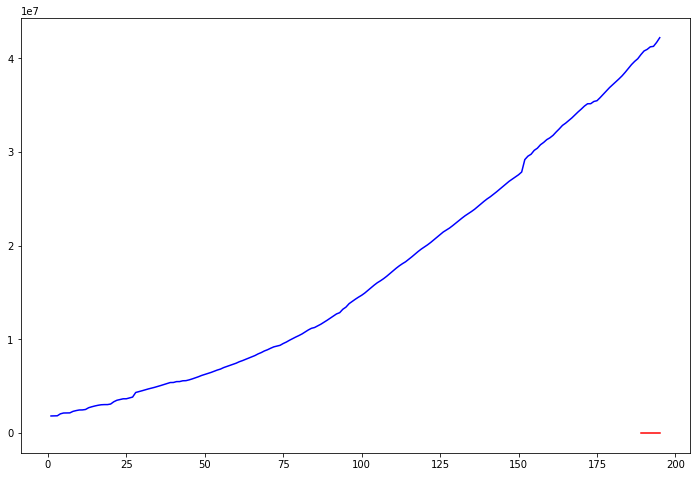

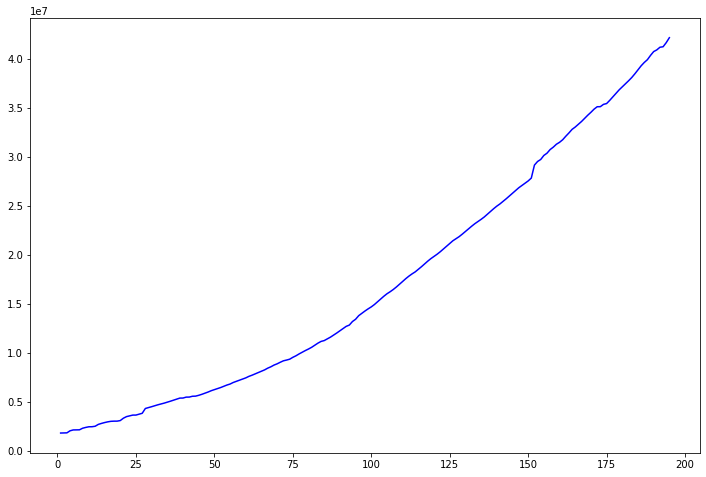

In [65]:
length = len(ConfirmedCases)

xAx = np.arange(1, length+1)
xAx2 = np.arange(length-6, length+1)
plt.figure(figsize=((12, 8)))
plt.plot(xAx, ConfirmedCases, color='blue')
plt.plot(xAx2, y_pred, color='red')
plt.show()

plt.figure(figsize=((12, 8)))
plt.plot(xAx, ConfirmedCases, color='blue')
plt.show()